In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import warnings
import emcee
import corner
import matplotlib as mpl

from jjmodel.input_ import p, a, inp
from jjmodel.mwdisk import disk_builder, local_run
from jjmodel.funcs import IMF
from jjmodel.populations import stellar_assemblies_r
from jjmodel.plotting import Plotting
from helpers import IMFHandler, SFRHandler, PopHandler, HessConstructor, extract_model_tables


Parameter file(s) : ok.
Number of parameters =  66 , among them technical =  7

 p(run_mode=0, out_dir='new_metgrid', out_mode=1, nprocess=4, Rsun=8.2, zsun=20, zmax=2000, dz=2, sigmad=29.3, sigmat=4.9, sigmag1=2.0, sigmag2=11.0, sigmadh=51.9, sigmash=0.47, td1=0, td2=7.8, dzeta=0.8, eta=5.6, pkey=1, tt1=0.1, tt2=4, gamma=2, beta=3.5, imfkey=0, a0=1.31, a1=1.5, a2=2.88, a3=2.28, m0=0.49, m1=1.43, m2=6.0, dFeHdt=0, n_FeHdt=1, fehkey=0, FeHd0=-0.7, FeHdp=0.29, rd=0.34, q=-0.72, FeHt0=-0.94, FeHtp=0.04, rt=0.77, t0=0.97, FeHsh=-1.5, dFeHsh=0.4, n_FeHsh=5, alpha=0.375, sige=26.0, sigt=45, sigdh=140, sigsh=100, sigmap=array([3.5, 1.3]), tpk=array([10. , 12.5]), dtp=array([0.7 , 0.25]), sigp=array([26.3, 12.6]))

Parameters checked: 0 Reminders, 0 Warnings, 0 Errors.

Configuration finished:  0h 0m 0.0s


In [48]:
mode_iso = 'BaSTI'
mode = 'wd'
radius = 50  # pc
mag_range = [[-0.4,1.65],[-1,18]]
mag_step = [0.02,0.2]
mag_smooth = [0.06,0.8]

if mode == 'ms+wd':
    hess_ref = np.loadtxt('data/hess/hess_tot.txt')
elif mode == 'ms':
    hess_ref = np.loadtxt('data/hess/hess_ms.txt')
else:
    hess_ref = np.loadtxt('data/hess/hess_wd.txt')

In [34]:
imf_handler = IMFHandler(p)
sfr_handler = SFRHandler(p, a, inp)
pop_handler = PopHandler(p, a, inp)
constructor = HessConstructor(radius, p, a)

out = local_run(p,a,inp,save=False,status_progress=False)
inp_tabs = extract_model_tables(out,inp)

imf_ref, (mass_binsc, IMF_ref) = imf_handler.create_reference_imf()

pop_tabs = pop_handler.create_reference_pop_tabs(imf_ref,mode_iso,wd=mode,FeH_scatter=0.07,Nmet_dt=7) # 
indt, indm = pop_handler.get_age_mass_idx(pop_tabs,mass_binsc)



Stellar population synthesis for R = 8.2 kpc:
	thin disk	thick disk	halo


In [54]:
shift = 0
hess = constructor.generate_hess(pop_tabs,indt['d'],inp_tabs,
                                 mag_range,mag_step,mag_smooth,
                                 color_shift=shift)

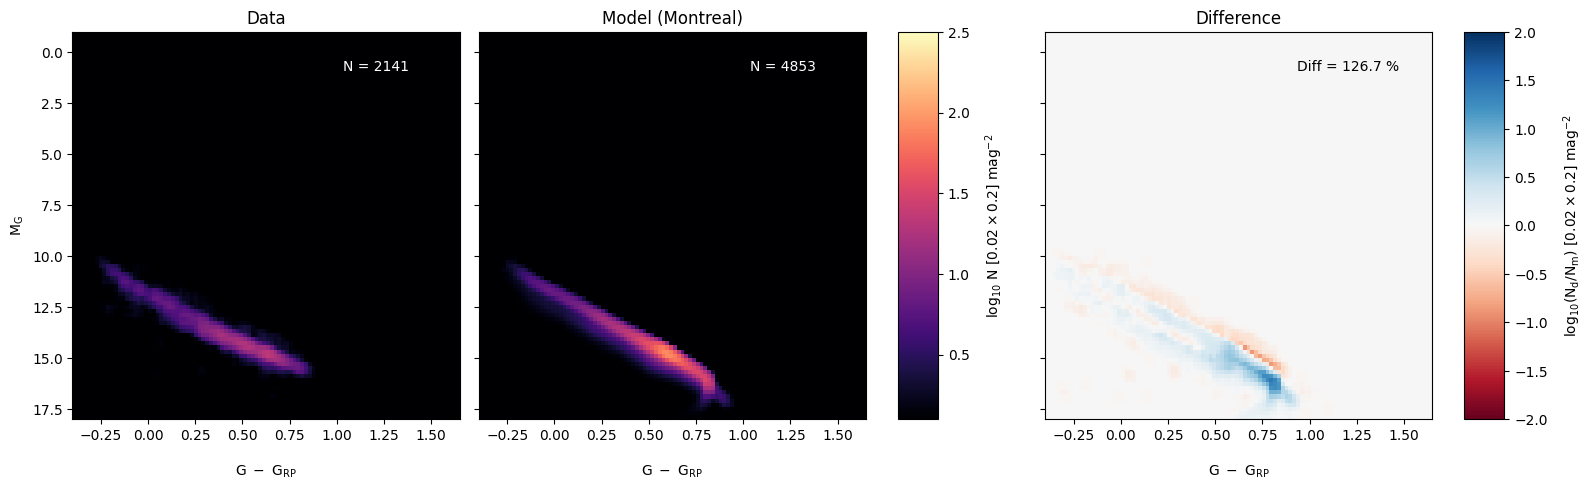

In [55]:
Ntot_d = int(round(sum(sum(hess_ref)),0))
Ntot_m = int(round(sum(sum(hess)),0))

fig, ax = plt.subplots(1,3,figsize=(16,5.5),sharey=True)

# Data
im1 = ax[0].imshow(np.log10(hess_ref+1),interpolation=None,cmap=mpl.colormaps['magma'],
               extent=[mag_range[0][0],mag_range[0][1],mag_range[1][1],mag_range[1][0]],
               vmin=0.1,vmax=2.5)
ax[0].text(0.7,0.9,'N = '+str(Ntot_d),color='w',transform=ax[0].transAxes)
ax[0].set_aspect(abs((mag_range[0][1]-mag_range[0][0])/(mag_range[1][1]-mag_range[1][0])))
ax[0].set_title('Data')
ax[0].set_xlabel(r'$\mathrm{G \ - \ G_{RP}}$',labelpad=15)
ax[0].set_ylabel(r'$\mathrm{M_G}$')

# Model
ax[1].imshow(np.log10(hess+1),interpolation=None,cmap=mpl.colormaps['magma'],
               extent=[mag_range[0][0],mag_range[0][1],mag_range[1][1],mag_range[1][0]],
               vmin=0.1,vmax=2.5)
ax[1].set_aspect(abs((mag_range[0][1]-mag_range[0][0])/(mag_range[1][1]-mag_range[1][0])))
ax[1].text(0.7,0.9,'N = '+str(Ntot_m),color='w',transform=ax[1].transAxes)
#ax[1].set_title('Model (' + mode_iso + ')')
ax[1].set_title('Model (Montreal)')
ax[1].set_xlabel(r'$\mathrm{G \ - \ G_{RP}}$',labelpad=15)


fig.subplots_adjust(left=0.05,wspace=0.05,right=0.8,top=0.93)
pos = ax[1].get_position()
cax = fig.add_axes([pos.x0+pos.width+0.02,pos.y0,0.025,pos.height])
cbar = fig.colorbar(im1,cax=cax,orientation='vertical')
cbar.set_label(r'$\mathrm{log_{10} \ N \ [' + str(mag_step[0]) +
               r'\times' + str(mag_step[1]) + r'] \ mag^{-2}}$',labelpad=10)

# Difference
diff = (np.log10(hess+1) - np.log10(hess_ref+1))#/(hess + 1)

pos_x2 = ax[2].get_position()
ax[2].set_position([pos_x2.x0+0.1,pos_x2.y0,pos_x2.width,pos_x2.height])

im2 = ax[2].imshow(diff,interpolation=None,cmap=mpl.colormaps['RdBu'],
               extent=[mag_range[0][0],mag_range[0][1],mag_range[1][1],mag_range[1][0]],
               vmin=-2.0,vmax=2.0)
ax[2].text(0.65,0.9,'Diff = '+str(np.round(100*(Ntot_m-Ntot_d)/Ntot_d,1))+' %',
           color='k',transform=ax[2].transAxes)
ax[2].set_aspect(abs((mag_range[0][1]-mag_range[0][0])/(mag_range[1][1]-mag_range[1][0])))
ax[2].set_xlabel(r'$\mathrm{G \ - \ G_{RP}}$',labelpad=15)
ax[2].set_title('Difference')

pos2_new = ax[2].get_position()
cax = fig.add_axes([pos2_new.x0+pos2_new.width+0.02,pos2_new.y0,0.025,pos2_new.height])
cbar = fig.colorbar(im2,cax=cax,orientation='vertical')
cbar.set_label(r'$\mathrm{log_{10}(N_{d}/N_{m}) \ [' + str(mag_step[0]) +
               r'\times' + str(mag_step[1]) + r'] \ mag^{-2}}$',labelpad=10)

#plt.savefig('m2d_montreal_newmet_' + mode_iso + '_' + mode + '_sf' + str(shift) + '.png')
plt.savefig('m2d_montreal_newmet_' + mode + '_sf' + str(shift) + '.png')
